In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

rows 688,cols 688
nrows 720,ncols 720


(<matplotlib.axes._subplots.AxesSubplot at 0x1d54b20c240>,
 Text(0.5, 1.0, 'phase'))

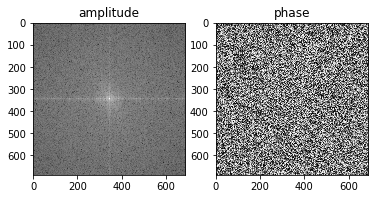

In [2]:
img = cv2.imread('images/fig0441.tif',0) #直接读为灰度图像
assert img.ndim == 2, 'img should be gray.'
rows,cols = img.shape[:2]
print('rows %s,cols %s' % (rows,cols))
#计算最优尺寸
nrows = cv2.getOptimalDFTSize(rows)
ncols = cv2.getOptimalDFTSize(cols)
print('nrows %s,ncols %s' % (nrows,ncols))
# 根据新尺寸，建立新变换图像
#nimg = np.zeros((nrows, ncols))
#nimg[:rows, :cols] = img
#print('nimg %s ' % nimg)
dft = cv2.dft(np.float32(img), flags=cv2.DFT_COMPLEX_OUTPUT)
# 换位，低频部分移到中间，高频部分移到四周
dft_shift  = np.fft.fftshift(dft)
f = np.fft.fft2(img)
fshift = np.fft.fftshift(f) # 快速傅里叶变换算法得到频率分布
img_a = np.log(np.abs(fshift)) # fft 结果是复数，求绝对值结果才是振幅
img_p = np.angle(fshift) # 取相位
plt.subplot(121),plt.imshow(img_a,'gray'),plt.title('amplitude')
plt.subplot(122),plt.imshow(img_p,'gray'),plt.title('phase')

In [3]:
def ifft(fft_mat):
    '''傅立叶反变换，返回反变换图像'''
    # 反换位，低频部分移到四周，高频部分移到中间
    f_ishift_mat = np.fft.ifftshift(fft_mat)
    # 傅立叶反变换
    img_back = cv2.idft(f_ishift_mat)
    # 将复数转换为幅度, sqrt(re^2 + im^2)
    img_back = cv2.magnitude(*cv2.split(img_back))
    # 标准化到0~255之间
    cv2.normalize(img_back, img_back, 0, 255, cv2.NORM_MINMAX)
    return np.uint8(np.around(img_back))

In [4]:
def fft_distances(m, n):
    '''
    计算m,n矩阵每一点距离中心的距离
    '''
    u = np.array([i if i<=m/2 else m-i for i in range(m)], dtype=np.float32)
    v = np.array([i if i<=n/2 else n-i for i in range(n)], dtype=np.float32)
    u.shape = m, 1
 
    # 每点距离矩阵左上角的距离
    ret = np.sqrt(u*u + v*v)
    # print(ret.shape)
    # 每点距离矩阵中心的距离
    return np.fft.fftshift(ret)

In [5]:
def filter(flag, dft_shift, d0,n=2):
    '''
    滤波器
    @param flag: 滤波器类型
    0 - 理想低通滤波
    1 - 巴特沃兹低通滤波
    2 - 高斯低通滤波
    3 - 理想高通滤波
    4 - 巴特沃兹高通滤波
    5 - 高斯高通滤波
    @param dft_shift: 被滤波的矩阵
    @param d0: 滤波器大小 D0
    @param n: 巴特沃兹低通滤波的阶数 
    @return 滤波器矩阵 
    '''
    rows = dft_shift.shape[0]
    cols = dft_shift.shape[1]
    filter_mat = None
    # 理想低通滤波
    if flag == 0:
        filter_mat = np.zeros((rows, cols, 2), np.float32)
        cv2.circle(filter_mat, (int(rows / 2), int(cols / 2)),d0, (1, 1, 1), thickness=-1)
    # 巴特沃兹低通滤波
    elif flag == 1: 
        duv = fft_distances(rows, cols)
        filter_mat = 1 / (1+ np.power(duv/d0, 2*n)) 
        # fft_mat有2个通道，实部和虚部
        # fliter_mat 也需要2个通道
        filter_mat =cv2.merge((filter_mat, filter_mat)) 
    # 高斯低通滤波
    elif flag == 2: 
        duv = fft_distances(rows, cols)
        filter_mat = np.exp(-(duv*duv) / (2*d0*d0))
        # fft_mat有2个通道，实部和虚部
        # fliter_mat 也需要2个通道
        filter_mat = cv2.merge((filter_mat, filter_mat))   
    # 理想高通滤波
    elif flag == 3: 
        filter_mat = np.ones((rows, cols ,2), np.float32)
        cv2.circle(filter_mat, (int(rows / 2), int(cols / 2)) , d0, (0,0,0), thickness=-1)  
    # 巴特沃兹高通滤波
    elif flag == 4: 
        duv = fft_distances(rows, cols)
        # duv有 0 值(中心距离中心为0)， 为避免除以0，设中心为 0.000001
        # print(' 0.5 rows %s, 0.5 cols %s' % ((rows-1)/2,(cols-1)/2))
        duv[int(rows/2), int(cols/2)] = 0.000001
        filter_mat = 1 / (1+ np.power(d0/duv, 2*n)) 
        # fft_mat有2个通道，实部和虚部
        # fliter_mat 也需要2个通道
        filter_mat =cv2.merge((filter_mat, filter_mat)) 
    # 高斯高通滤波
    else: 
        duv = fft_distances(rows, cols)
        filter_mat = 1 - np.exp(-(duv*duv) / (2*d0*d0))
        # fft_mat有2个通道，实部和虚部
        # fliter_mat 也需要2个通道
        filter_mat = cv2.merge((filter_mat, filter_mat)) 
        
    #print('filter_mat %s'%filter_mat)
    return filter_mat

In [6]:
COF_5 = 5     # 截止频率 5
COF_15 = 15   # 截止频率 15
COF_30 = 30   # 截止频率 30
COF_50 = 50   # 截止频率 50
COF_80 = 80   # 截止频率 80
COF_150 = 150 # 截止频率 150
COF_250 = 250 # 截止频率 250
# 滤波器类型
FILTER_TYPE={
             'ILPF':0,  # 理想低通滤波器
             'BLPF':1,  # 巴特沃斯低通滤波器
             'GLPF':2,  # 高斯低通滤波器
             'IHPF':3,  # 理想高通滤波器
             'BHPF':4,  # 巴特沃斯高通滤波器
             'GHPF':5,  # 高斯高通滤波器
            }


In [7]:
def showProcessedImageByFilter(filterType,title,COFs):
    assert len(COFs) == 4,'COFs length should be 4'
    fig, axes = plt.subplots(nrows=2, ncols=2,subplot_kw={'xticks': [], 'yticks': []},figsize=(16,6))
#     plt.figure(figsize=(20,20))
    fig.suptitle(title)
    for ax, COF in zip(axes.flat[:], COFs):
        pf = filter(filterType,dft_shift,COF)
        filtered_mat = pf * dft_shift # 进行滤波
        img_back = ifft(filtered_mat) # 反变换    
        ax.imshow(img_back, cmap = 'gray')
        ax.set_title('cut-off frequency: %s' % COF)
    plt.show()

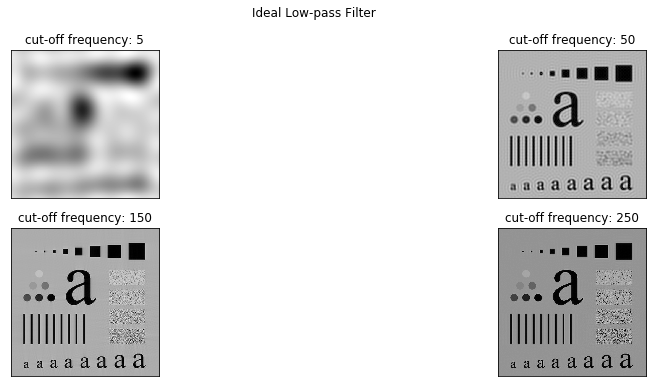

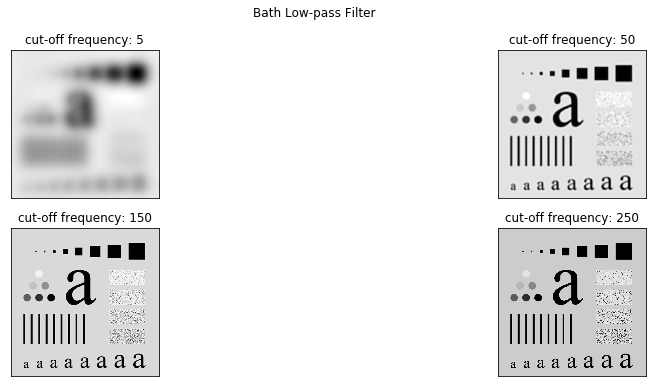

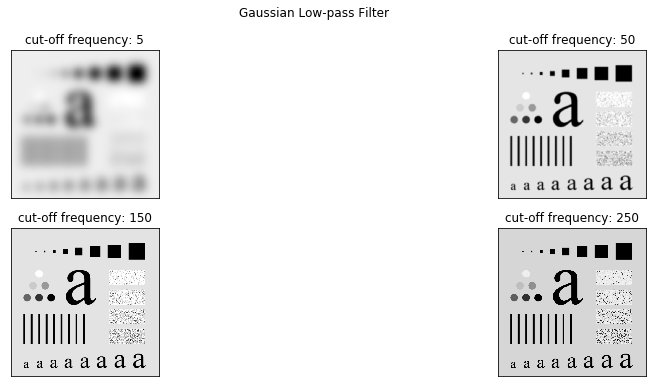

In [8]:
COFs = [COF_5,COF_50,COF_150,COF_250]
showProcessedImageByFilter(FILTER_TYPE['ILPF'],'Ideal Low-pass Filter',COFs)
showProcessedImageByFilter(FILTER_TYPE['BLPF'],'Bath Low-pass Filter',COFs)
showProcessedImageByFilter(FILTER_TYPE['GLPF'],'Gaussian Low-pass Filter',COFs)

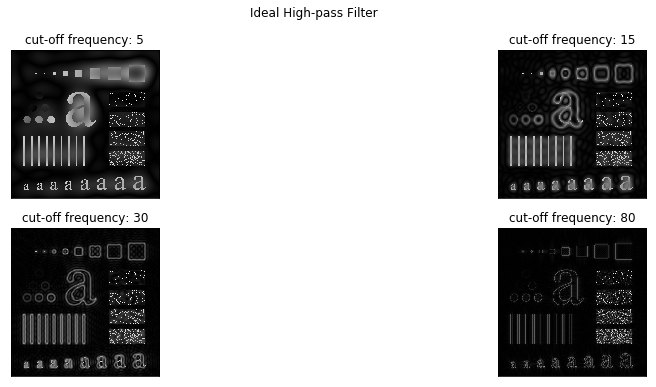

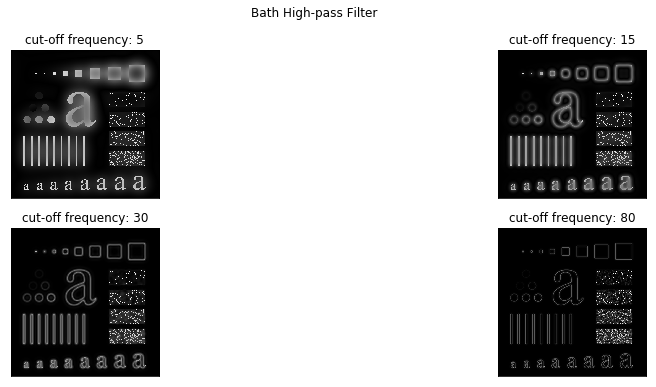

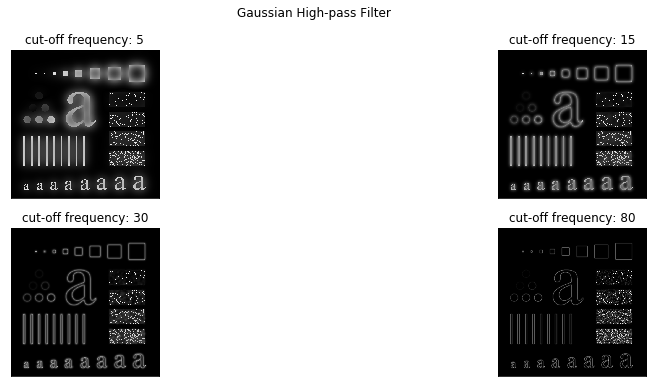

In [9]:
COFs = [COF_5,COF_15,COF_30,COF_80]
showProcessedImageByFilter(FILTER_TYPE['IHPF'],'Ideal High-pass Filter',COFs)
showProcessedImageByFilter(FILTER_TYPE['BHPF'],'Bath High-pass Filter',COFs)
showProcessedImageByFilter(FILTER_TYPE['GHPF'],'Gaussian High-pass Filter',COFs)